Please enter the number of iterations: 1000
please input the duration number in order to determine the probability that the total project duration exceed this random input156
Input a number (n) between 1 and 1000: 364
Probability of the total duration exceeds the given duration is 0.0
Path_2    562
Path_1    427
Path_3     11
Name: Critical Path, dtype: int64
{1: ['A', 'C', 'F', 'I'], 2: ['B', 'D', 'F', 'I'], 3: ['B', 'D', 'G', 'I'], 4: ['B', 'D', 'H'], 5: ['B', 'E', 'H']}
{'A': 42.7, 'B': 57.3, 'C': 42.7, 'D': 57.3, 'E': 0.0, 'F': 98.9, 'G': 1.1, 'H': 0.0, 'I': 100.0}
A
A_TF


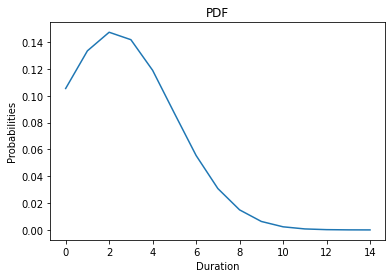

B
B_TF


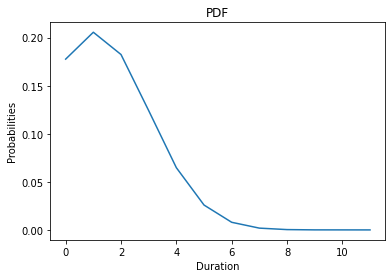

C
C_TF


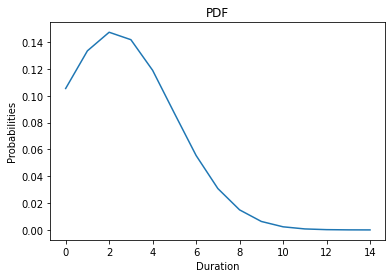

D
D_TF


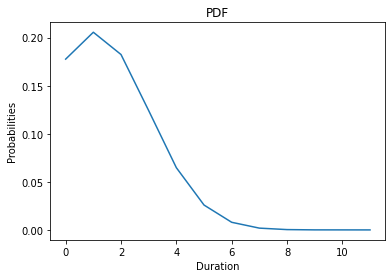

E
E_TF


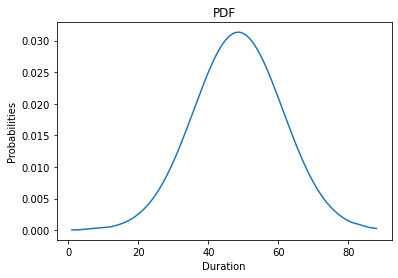

F
F_TF


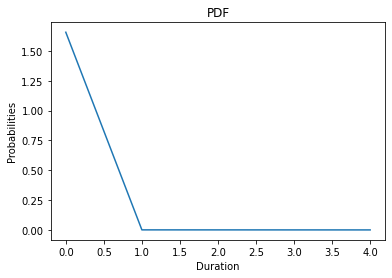

G
G_TF


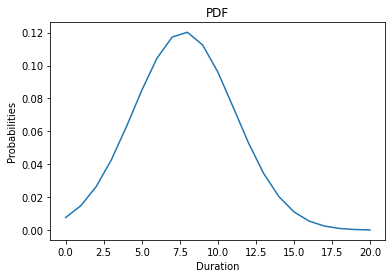

H
H_TF


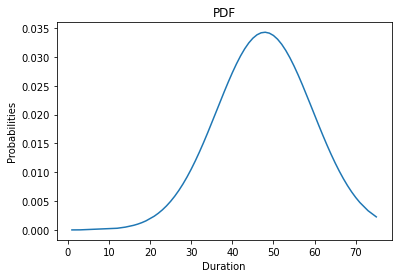

I
I_TF


/usr/local/lib/python3.8/dist-packages/scipy/stats/_distn_infrastructure.py:1870: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


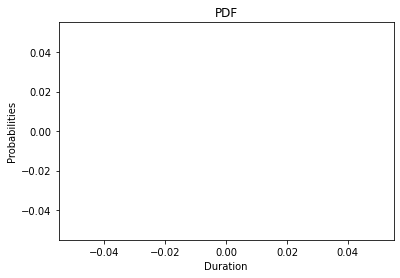

   index Critical Path  same_path  same_path_percentage
0      0        Path_1        327                  32.7
1      1        Path_2        509                  50.9
2      2        Path_3          9                   0.9


In [16]:
# -*- coding: utf-8 -*-
"""Binakisibakchodi.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1_zQgpPGL2x70oaKP9zlQ87Fifu5BEDF_
"""

"""

Description: Monte carlo simulations.
Assignment:  A4 - Monte Carlo Simulation

Author: Mehulkumar Jariwala and Akshaykumar Dhorajiya

Due Date: 8TH DEC, 2022

Language: PYTHON3

Not Addressed: N/A - all requirements of the assignments are addressed

Input: Please note the following:
        1. Change the CSV filepath on line #528 when inserting new CSV files.
        2. Please ensure the new CSV files are in the SAME DIRECTORY.
        3. please ensure that the new csv should contain the values in exact manner that are provided for the csv file

Output: The following output is shown:
        1. Using matplotlib, png(s) are generated as well as saved in the directory: ./Q1_Plots/
            Plots include:
                - Q.i.b. Project PDF.png - Probabilities vs  Duration after num_iterations
                - Q.ii.a) Probability of each activity belonging to the critical path.png - after num_iterations iterations
                - Q.ii.b. {input_activity}_TF.png - Duration vs probabilty after num_iterations iterations can be seen in the output compiler
        2. Text  generated:
                - Q.i.a Project Duration.txt - Statistics like Mean/STD of Project after num_iterations iterations 
                - Q.ii.a probailty of being critical for each activity can be found in the run compile in the simmilar context as given below
                {1: ['A', 'C', 'F', 'I'], 2: ['B', 'D', 'F', 'I'], 3: ['B', 'D', 'G', 'I'], 4: ['B', 'D', 'H'], 5: ['B', 'E', 'H']}
{'A': 38.506, 'B': 61.495, 'C': 38.506, 'D': 61.482, 'E': 0.013, 'F': 98.486, 'G': 1.502, 'H': 0.013, 'I': 99.988}
                - Q.ii.b.1 {input_activity}_FF.txt - Statistics like Mean/STD of the user input activity after num_iteration iterations
        3. CSV Files generated in directory: ./Data/
                - cdf_data.csv - Ascending order of Max(Total_Duration of all paths), Emperical CDF
                - data_until_{n_number}_iterations.csv - Activity, ES, EF, LS, LF, TF, FF, Iteration until user input: 1 <= n_number <= num_iterations
                - iteration_data.csv - Random Numbers Generated for each Activity, Path Durations, Total Duration, Critical Path, Activity FF for all activities

Algorithm: The following data structures / algorithms were used:
        1. Class Node to store activity information (ES, EF, LS, LF, TF, LF, predecessors, successors, 
           is_critical, distribution, mean, sd, cov, variance, rv)
        2. A recursive forward and backward implementation is used to ensure that the formulae to calculate the 
           activity parameters is satisfied.
        3. Get all possible paths from Start to End using DFS Graph Algorithm
        4. use of the scipy library to get the inv distribution number for given mean and sd for given distribution from range of uniformally distributed number [0,1]
        5. Begin Iteration (1 to num_iteration):
            5.1. For each iteration, generate a random_number for each node based on the its distribution
            5.2. Set node.rv = node.duration = random_number generated
            5.3. Perform forward and backward iteration to calculate ES, EF, LS, LF, TF, FF for nodes whose duration is set in step 5.2
            5.4. For all paths (step 3), calculate their total duration by adding the duration of nodes comprising the path
            5.5. Store data from steps 5.3 and 5.4 in separate dataframes and pass them to cdf_statistics() or activity_ff_statistics() functions accordingly

Known Bugs: 
    if the path number is greater than 5, the code can not generate the probability of only path being critical.

    

"""

from __future__ import annotations
import json
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
from numpy.core.arrayprint import StructuredVoidFormat, _guarded_repr_or_str
from numpy.core.fromnumeric import size
from numpy.lib.arraypad import pad
import os
from pandas.plotting import table 
import pandas as pd
import sys
from typing import SupportsComplex


class Node:
    activity: str                           # Stores activity name
    duration: int                       # Stores activity duration
    es: int                             # Early Start
    ef: int                             # Early Finish
    ls: int                             # Late Start
    lf: int                             # Late Finish
    tf: int                             # Total Float
    ff: int                             # Float
    
    prev: list[Node]                    # Predecessor Nodes
    next: list[Node]                    # Successor Nodes
    
    is_critical: str                    # Is node critical or not
    
    distribution: str
    mean: int
    cov: int
    sd: int
    variance: int
    rv: int

    # Initializer
    def __init__(self, activity, distribution, mean):
        self.activity = activity
        self.duration = 0
        self.es = None
        self.ef = None
        self.ls = None
        self.lf = None
        self.tf = None
        self.ff = None

        self.prev = []
        self.next = []

        self.is_critical = "No"

        self.distribution = distribution
        self.mean = mean
        self.cov = 0
        self.sd = 0
        self.variance = 0
        self.rv = 0


    # Function to print the Node object
    def __repr__(self) -> str:
        return "{" \
            f"\"Activity\":\"{self.activity}\", " \
            f"\"Duration\":\"{self.duration}\", " \
            f"\"ES\":\"{self.es}\", " \
            f"\"EF\":\"{self.ef}\", " \
            f"\"LS\":\"{self.ls}\", " \
            f"\"LF\":\"{self.lf}\", " \
            f"\"TF\":\"{self.tf}\", " \
            f"\"FF\":\"{self.ff}\", " \
            f"\"prev\":\"{list(map(lambda node: node.activity, self.prev))}\", " \
            f"\"next\":\"{list(map(lambda node: node.activity, self.next))}\", " \
            f"\"Distribution\":\"{self.distribution}\", " \
            f"\"Mean\":\"{self.mean}\", " \
            f"\"COV\":\"{self.cov}\", " \
            f"\"SD\":\"{self.sd}\", " \
            f"\"Var\":\"{self.variance}\", " \
            f"\"RV\":\"{self.rv}\", " \
            f"\"Critical Path\":\"{self.is_critical}\"" \
            "}\n"

    def get_duration(self):
        return self.duration

    def set_duration(self, duration):
        self.duration = duration

    def get_ES(self):
        return self.es
    
    def set_ES(self, ES):
        self.es = ES

    def get_EF(self):
        return self.ef

    def set_EF(self, EF):
        self.ef = EF

    def get_LS(self):
        return self.ls
    
    def get_LF(self):
        return self.lf

    def get_FF(self):
        return self.ff

    def is_Critical(self):
        return self.is_critical

    def get_successors(self):
        return self.next

    def get_activity(self):
        return self.activity

    def get_TF(self):
        return self.tf

    def set_sd(self, sd):
        self.sd = sd
    
    def set_variance(self, variance):
        self.variance = variance

    def set_rv(self, rv):
        self.rv = rv

    def get_rv(self):
        return self.rv

# Read the csv file and returns a pandas df object
def read_csv(path):
    return pd.read_csv(path)

# Generates nodes from the input csv
def generate_nodes(csv) -> list[str, Node]:

    # Add the Start and End nodes manually
    nodes = {
        "Start": Node(activity="Start", distribution="N/A", mean=0),
        "End": Node(activity="End", distribution="N/A", mean=0)
    }

    csv = csv.rename(columns=lambda x: x.strip())
    columns = csv.columns

    # Iterate through the dataframe
    for index, row in csv.iterrows():
        if row["Activity"] not in nodes:
            # Add new nodes
            activity = row["Activity"]
            distribution = row["Distribution Type"]
            mean = row["Mean (days)"]
            cov = row["COV"]
            node = Node(activity, distribution, mean)
            try:
                cov = float(cov)
                
                # Standard_Deviation = COV * mean
                sd = cov * mean
            except:
                cov = 0.0

                # TODO - confirm that only Exponential doesn't have cov
                sd = mean

            node.cov = cov
            node.set_sd(float("{:.2f}".format(sd)))
            node.set_duration(mean)

            # Variance is the square of standard_deviation
            node.set_variance(float("{:.2f}".format(sd**2)))

            # Add node to nodes
            nodes[activity] = node

    # Iterate to keep track of prev and next nodes
    for index, row in csv.iterrows():
        # Dependency list
        current = row["Activity"].strip()
        dependents = row["Predecessors"].strip().split(",")
        for dependent in dependents:
            dependent = dependent.strip()
            # All predecessors and successors
            if dependent.isalpha():
                nodes[current].prev.append(nodes[dependent])
                nodes[dependent].next.append(nodes[current])

    # Connect the start and end nodes
    for node in filter(lambda node: node.activity not in ["Start", "End"], nodes.values()):
        if not node.next:
            node.next.append(nodes["End"])
            nodes["End"].prev.append(node)

        if not node.prev:
            node.prev.append(nodes["Start"])
            nodes["Start"].next.append(node)

    return nodes

# Forward traversing - to set ES and EF values
def forward(end: Node):
    node = end
    max_es = 0

    for predecessor in node.prev:
        forward(end=predecessor)
        max_es = max(max_es, predecessor.ef)
    # Early start is the maximum value of predecessors EF values
    node.es = max_es
    node.ef = node.es + node.duration

# Backward traversing - to set LS and LF values
def backward(end: Node):
    node = end
    min_lf = sys.maxsize
    min_ff = sys.maxsize

    for successor in node.next:
        if (successor.activity != "End"):
            backward(end=successor)
        min_lf = min(min_lf, successor.ls)
        min_ff = min(min_lf, successor.es - node.ef)

    # Late finish is the minimum value of successors LS values
    node.lf = min_lf
    node.ls = node.lf - node.duration

    # Set is_critical to True if node is critical
    node.tf = node.ls - node.es

    if (node.tf == 0):
        node.is_critical = "Yes"

    node.ff = min_ff

#
def get_df_from_nodes(nodes):
    df = []
    for node in nodes.values():
        node_str = repr(node)
        node_dict = json.loads(node_str)
        df.append(node_dict)

    df = pd.DataFrame.from_dict(df)
    df.drop(columns=["prev", "next"], axis=1, inplace=True)
    # df = df[~df["Activity"].isin(["Start", "End"])]
    # df['Color'] = df.apply(color, axis=1)    

    return df

# Identifies critical nodes and returns the number of critical nodes in the program
def set_critical_nodes(nodes):
    # Set is_critical to "Yes" if node is critical
    num_critical = 0
    for node in nodes.values():
        if (node.es - node.ls == 0):
            node.is_critical = "Yes"
            node.tf = 0
            num_critical += 1
        else:
            node.tf = node.ls - node.es
    return num_critical

# Helper function to check if a node is critical
def is_critical(node):
    if node["Critical Path"] == "Yes":
        return True
    return False

# Traverses all nodes and forms a (src, dest) tuple of only the critical nodes
def get_edges(nodes):
    edges = []
    for curr in nodes.values():
        src_dict = json.loads(repr(curr))

        src = src_dict["Activity"]
        # Loop through successors
        successors = src_dict["next"].lstrip("[").rstrip("]").split(",")
        if (successors != ['']):
            for nxt in successors:
                dest = json.loads(repr(nodes[nxt.lstrip(" '").rstrip("'")]))
                edges.append((src, dest["Activity"]))

    return edges

# Represents a graph data structure using adjacency list
def make_graph(edges):
    adjlist = {}
    for (src, dest) in edges:
        if src not in adjlist:
            adjlist[src] = {dest: 1}
        else:
            # Add new dest node
            adjlist[src][dest] = 1

    # Manually add the "End" node
    adjlist["End"] = {}
    return adjlist

# Function to perform DFS traversal in a directed graph to find the
# complete path between source and destination vertices
def find_all_paths(graph, start, end, path):
    # include the current node in the path
    path = path + [start]
    if start == end:
        return [path]
    if start not in graph:
        return []
    paths = []
    for node in graph[start]:
        # proceed if node is not discovered
        if node not in path:
            newpaths = find_all_paths(graph, node, end, path)
            for newpath in newpaths:
                paths.append(newpath)
    return paths

# create a column with to color the critical path
def color(row):
    c_dict = {'Yes':'#E64646', 'No':'#3475D0'}
    return c_dict[row['Critical Path']]

# Save Gantt-Chart to directory
def save_gantt_chart(df, title, proj_start, proj_end, xlabel, ylabel):
    
    fig, ax = plt.subplots(1, figsize=(16,6))

    # Plot Legends
    c_dict = {'Critical':'#E64646', 'Non-Critical':'#3475D0'}
    legend_elements = [Patch(facecolor=c_dict[i], label=i)  for i in c_dict]
    plt.legend(handles=legend_elements)

    # Plot Ticks
    xticks = np.arange(0, proj_end+2, 1)
    xticks_labels = np.arange(proj_start, proj_end+2)

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks_labels[::1])

    # Gantt Chart
    ax.barh(df.Activity, pd.to_numeric(df.Duration), left=pd.to_numeric(df.ES), color=df.Color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.gca().invert_yaxis()

    # Save the figure
    if not os.path.exists(f'./{title[0:2]}_Plots/'):
        os.makedirs(f'./{title[0:2]}_Plots/')

    plt.savefig(f'./{title[0:2]}_Plots/' + title + ".png")
    
    # Clear the current figure
    plt.clf()

    #iii. a) Probability that it is critical path
    #     b) Probability that it is the only critical path
def new_df1(path_df,num_iterations):
  path_df["same_path"]= path_df.apply(lambda x: x.Path_1 == x.Path_2 or x.Path_1 == x.Path_3 or x.Path_1 == x.Path_4 or x.Path_1==x.Path_5 or x.Path_2==x.Path_3 or x.Path_2==x.Path_4 or x.Path_2==x.Path_5 or x.Path_3==x.Path_4 or x.Path_3==x.Path_5 or x.Path_4==x.Path_5,axis=1)
  
  same_path_df = path_df[path_df["same_path"]==False]

  same_path_df = same_path_df[["same_path", "Critical Path"]]
  path_count = same_path_df.groupby(by="Critical Path", dropna=False, as_index=False).count().reset_index()
  path_count["same_path_percentage"] = (path_count["same_path"]/num_iterations)*100

  print(path_count)


def save_histogram(df, nodes, num_iterations, path_dict, title, xlabel, ylabel):

    activity_probabilities = {}

    path_values = df["Critical Path"].value_counts()
    path_probabilities = {}

    for path, occurrance in path_values.iteritems():
        path_probabilities[path] = float("{:.5f}".format(occurrance / num_iterations))

    print(path_values)
    print(path_dict)

    for node in nodes.values():
        activity = node.get_activity()
        if activity == "Start" or activity == "End": continue
        activity_probability = 0.0

        # Check if activity belongs to critical paths
        for key, path in path_dict.items():
            path_key = "Path_" + str(key)
            if activity in path:
                activity_probability += path_probabilities[path_key] if path_key in path_probabilities else 0.0
        
        activity_probabilities[activity] = float("{:.3f}".format(activity_probability * 100))

    print(activity_probabilities)

    # Plot Histogram
    plt.bar(list(activity_probabilities.keys()), activity_probabilities.values())
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(list(activity_probabilities.keys()))
    
    # Save the figure
    if not os.path.exists(f'./{title[0:2]}_Plots/'):
        os.makedirs(f'./{title[0:2]}_Plots/')

    plt.savefig(f'./{title[0:2]}_Plots/' + title + ".png")

    # Clear the current figure
    plt.clf()

# Generate a PNG from pandas dataframe
def save_table(df, title, str_):
    
    fig, ax = plt.subplots()
    # hide axes
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.patch.set_facecolor('white')

    # Create a table from df values
    table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.auto_set_column_width(col=list(range(len(df.columns))))
    table.scale(1,2)

    if (str_ is not None):
        plt.suptitle(f"{str_}")

    # plt.autoscale()
    plt.savefig(f'./{title[0:2]}_Plots/' + title + ".png", transparent=False)
    
    plt.clf()





from numpy.core.fromnumeric import shape
import scipy
from scipy.stats import expon
import random

CSV_PATH = "/content/Assignment_4.csv"


# Returns a random number from a normal distribution
def random_normal(mean, sd):
    s=random.random()
    return round((scipy.stats.norm.ppf(s,loc= mean,scale=sd)))

# Returns a random number from a gamma distribution
def random_gamma(mean, sd):
    # Parameter Estimation using Max-Likelihood Method
    s=random.random()
    shape = (mean**2) / (sd**2)
    beta = (sd**2) / mean  
    y=(scipy.stats.gamma.ppf(s,shape,loc= mean,scale=1/sd))
    if math.isinf(y):
      return 0
    else:
      return round(y)


# Returns a random number from an exponential distribution
def random_exponential(mean):  
  s=random.uniform(0,0.99999)
  return round(scipy.stats.expon.ppf(s,loc=mean,scale=1))                                   # Mean = 32; STD = 1    # Project Duration close to 200
    

# Returns a random number from a log normal distribution
def random_log_normal(mean, sd):
    s= random.random()
    a=scipy.stats.lognorm.ppf(s,sd,loc=mean,scale=sd)
    if mean-sd<a<mean+sd:
      return round(a)
    elif a< mean-sd:
      a=mean-sd 
      return round(a)
    else:
      a=mean+sd 
      return round(a)

    
    # return lognorm.rvs(s=sd, loc=mean)

# Returns a random number from a gumbel distribution
def random_gumbel(mean):
    s=random.uniform(0,0.99999)
    return round(scipy.stats.gumbel_l.ppf(s,loc= mean,scale=sd))
    
# Write the Project Duration Statistics to a text file
def get_statistics(cdf_df, num_iterations):
    # Mean of Total Duration
    mean = float("{:.2f}".format(cdf_df["Total_Duration"].mean()))
    std = float("{:.2f}".format(cdf_df['Total_Duration'].std()))

    # Write the Project Estimates in a file
    with open('./Q1.i.a) Project Duration.txt', 'w') as f:
            f.write(f"Mean and Standard Deviation of the project after {num_iterations} iterations:\n\n")
            f.write(f"Mean: {mean}\n")
            f.write(f"Standard Deviation: {std}\n")
    f.close()
# save the project pdf as a plot
def pdf_statistics(path_df,num_iterations):
  pdf_df  = path_df[["Total Duration"]].copy()
  pdf_df =  pdf_df.sort_values("Total Duration")
  pdf_df = pdf_df.rename(columns={'Total Duration': 'Total_Duration'})
  
  pdf_df_mean= np.mean(pdf_df["Total_Duration"])
  pdf_df_std= np.std(pdf_df["Total_Duration"])
  pdf = scipy.stats.norm.pdf(pdf_df["Total_Duration"],loc=pdf_df_mean,scale=pdf_df_std)

  plt.plot(pdf_df["Total_Duration"],pdf)
  plt.title("PDF")
  plt.xlabel("Duration")
  plt.ylabel("Probabilities")
  
  get_statistics(pdf_df, num_iterations)
  if not os.path.exists(f'./Q1_Plots/'):
    os.makedirs(f'./Q1_Plots/')

  plt.savefig(f'./Q1_Plots/' + "Q1.i.b) Project pDF" + ".png")
  plt.clf()
  return pdf_df
# Save the Project CDF as a scatter plot
def cdf_statistics(path_df, num_iterations):
    # Sort the critical path timings
    cdf_df = path_df[["Total Duration"]].copy()
    cdf_df = cdf_df.sort_values("Total Duration")

    cdf_df = cdf_df.rename(columns={'Total Duration': 'Total_Duration'})
    
    cdf_df.index = np.arange(1, len(cdf_df) + 1)
    cdf_df["Row"] = cdf_df.index

    constant = num_iterations + 1
    cdf_df["Emperical_CDF"] = cdf_df.apply(lambda row: float("{:.2f}".format(row["Row"]*100.0 / constant)), axis=1)



    get_statistics(cdf_df, num_iterations)

    return cdf_df
def exceeds(cdf_df,input_duration,num_iterations):
    df=cdf_df
    R= (len(df[df['Total_Duration']>input_duration]))    
    exceeded_probability= print('Probability of the total duration exceeds the given duration is',(R/num_iterations)*100   ) 
    return exceeded_probability



# Plot the Activity_TF as a scatter plot
def activity_ff_statistics(path_df, input_activity):
  for a in input_activity:
    activity = a + "_TF"
    print(activity)
    # Mean of Total Duration
    mean = float("{:.2f}".format(path_df[activity].mean()))
    std = float("{:.2f}".format(path_df[activity].std()))
    # Write the Project Estimates in a file
    with open('./Q1.ii.b) ' + activity + '.txt', 'w') as f:
            f.write(f"Mean and Standard Deviation of the Activity {input_activity} Total Float (TF) after {num_iterations} iterations:\n\n")
            f.write(f"Mean: {mean}\n")
            f.write(f"Standard Deviation: {std}\n")
    f.close()
    
    activity_df = path_df[[activity]].copy()
    
    activity_df = activity_df.sort_values(activity)
    activity_df = activity_df.rename(columns={activity: 'TF'})
    
    pdf = scipy.stats.norm.pdf(activity_df["TF"],loc=mean,scale=std)
    plt.plot(activity_df["TF"],pdf)
    plt.title("PDF")
    plt.xlabel("Duration")
    plt.ylabel("Probabilities")
    plt.show()
    activity_df.index = np.arange(1, len(activity_df) + 1)
    activity_df["Row"] = pdf_df.index

    constant = num_iterations + 1
    #activity_df["Emperical_TF"] = pdf_df.apply(lambda row: float("{:.2f}".format(row["Row"]*100.0 / constant)), axis=1)

    max_duration = activity_df["TF"].max()
    min_duration = activity_df["TF"].min()

   

 
 
 

if __name__ == "__main__":
    # User Input - Number of Iterations
    num_iterations = int(input("Please enter the number of iterations: "))


    input_duration = float(input("please input the duration number in order to determine the probability that the total project duration exceed this random input"))
    csv = read_csv(CSV_PATH)

    nodes = generate_nodes(csv)
    activities = csv["Activity"]
    
    #for input_activity in activities:

      # User Input - Activity to plot its TF
   

      # User Input - Number between 1 and num_iterations
    n_number = int(input(f"Input a number (n) between 1 and {num_iterations}: "))

      # Get the first project duration by setting duration to mean
    start = nodes["Start"]
    end = nodes["End"]

      # Populate earliest start and finish by recursing until the end node
    forward(end=end)

      # Update "end" late start and finish values
    end.ls = end.lf = end.es

      # Populate late start and finish by recursing until the start node
    backward(end=start)

    df = get_df_from_nodes(nodes)
    edges = get_edges(nodes)
    graph = make_graph(edges)


      # List to store the complete path between source and destination
    paths = find_all_paths(graph, "Start", "End", [])
    for path in paths:
        path.remove("Start")
        path.remove("End")

    path_dict = {index + 1 : path for index,path in enumerate(paths)}
    path_info = []
    n_num_info = []
    n_num_mean_duration = []
    
    for iteration in range(1, num_iterations + 1):

        iteration_dict = {}
        # Generate a random number for each activity based on its distribution
        for node in nodes.values():
            node_str = repr(node)
            node_dict = json.loads(node_str)

            if node_dict["Activity"] == "Start" or node_dict["Activity"] == "End": continue

            distribution = node_dict["Distribution"]
            mean = int(node_dict["Mean"])
            sd = float(node_dict["SD"])
            var = float(node_dict["Var"])

            random_num = 0
              # Call functions accordingly
            if (distribution == "Normal"):
                random_num = random_normal(mean, sd)
            elif (distribution == "Gamma"):
                random_num = random_gamma(mean, sd)
            elif (distribution == "Log-normal"):
                 random_num = random_log_normal(mean, sd)
            elif (distribution == "Exponential"):
                  random_num = random_exponential(mean)
            elif (distribution == "Gumbel"):
                  random_num = random_gumbel(mean)

            node.set_rv(float("{:.2f}".format(random_num)))
            node.set_duration(float("{:.2f}".format(random_num)))       # Set Duration as random number generated

          # Forward and Backward Pass
        start = nodes["Start"]
        end = nodes["End"]

          # Populate earliest start and finish by recursing until the end node
        forward(end=end)

          # Update "end" late start and finish values
        end.ls = end.lf = end.es
          
        if (iteration <= n_number):
            n_num_mean_duration.append(end.es)

          # Populate late start and finish by recursing until the start node
        backward(end=start)

          # Note the Random Values Generated
        for node in nodes.values():
              node_str = repr(node)
              node_dict = json.loads(node_str)
              if node_dict["Activity"] == "Start" or node_dict["Activity"] == "End": continue
              iteration_dict[node_dict["Activity"]] = node.get_rv()

          # Iterate through the paths and calculate their duration
        for path_num, path in path_dict.items():
              # Add the node rv to get path delay
              path_delay = 0.0
              for activity in path:
                  path_delay += nodes[activity].get_rv()

              iteration_dict["Path_" + str(path_num)] = float("{:.2f}".format(path_delay))
              

          # Identify the critical path having maximum duration
        max_key = max(iteration_dict, key=iteration_dict.get)
        all_values = iteration_dict.values()
        max_value = max(all_values)

        iteration_dict["Total Duration"] = max_value
        iteration_dict["Critical Path"] = max_key

          # Maintain ES, EF, LS, LF and FF values
        for node in nodes.values():
              n_num_dict = {}
              node_str = repr(node)
              node_dict = json.loads(node_str)

              if node_dict["Activity"] == "Start" or node_dict["Activity"] == "End": continue

              iteration_dict[node_dict["Activity"] + "_TF"] = node.get_TF()

              n_num_dict["Iteration"] = iteration
              n_num_dict["Activity"] = node.get_activity()
              n_num_dict["Duration"] = node.get_duration()
              n_num_dict["ES"] = float("{:.2f}".format(node.get_ES()))
              n_num_dict["EF"] = float("{:.2f}".format(node.get_EF()))
              n_num_dict["LS"] = float("{:.2f}".format(node.get_LS()))
              n_num_dict["LF"] = float("{:.2f}".format(node.get_LF()))
              n_num_dict["TF"] = float("{:.2f}".format(node.get_TF()))
              n_num_dict["FF"] = float("{:.2f}".format(node.get_FF()))
              n_num_dict["Critical Path"] = node.is_Critical()

              if (iteration <= n_number):
                  n_num_info.append(n_num_dict)

        iteration_dict["Iteration"] = iteration
        path_info.append(iteration_dict)
          
    path_df = pd.DataFrame(path_info)
    n_num_df = pd.DataFrame(n_num_info)
      
      # Write to CSV
    if not os.path.exists('./Data/'):
                              os.makedirs('./Data/')

    path_df.to_csv('./Data/iteration_data.csv', header=True, index=None, sep=',', mode='w')

      # Write to CSV
    if not os.path.exists('./Data/'):
                              os.makedirs('./Data/')

    n_num_df.to_csv(f'./Data/data_until_{n_number}_iterations.csv', header=True, index=None, sep=',', mode='w')


      # Plot CDF and Generate Statistics
    cdf_df = cdf_statistics(path_df, num_iterations)
    pdf_df = pdf_statistics(path_df, num_iterations)
      # Generate confidence statistics for the user input
    #confidence_statistics(cdf_df, confidence_level)
      # Generate the exceeded duration probabilites
    exceeds(cdf_df,input_duration,num_iterations)

      # Generate histogram for probabilities of each activities
    save_histogram(path_df, nodes, num_iterations, path_dict, "Q1.ii.a) Probability of each activity belonging to the critical path", "Critical Path", "Probability")

      # Generate input_activity FF statistics
    for node in nodes.values():
        activity = node.get_activity()
        if activity == "Start" or activity == "End": continue
        input_activity=activity
        print(input_activity)
        activity_ff_statistics(path_df,input_activity )
        continue
      #new df
    new_df1(path_df,num_iterations)
    

      # Mean Duration for n_num iterations
    n_mean_duration = float("{:.2f}".format(np.mean(n_num_mean_duration)))
    with open('./Q1.v. Project Duration.txt for acitvity'+str(input_activity), 'w') as f:
             f.write(f"Number of Iterations: {n_number}\nMean Project Duration: {n_mean_duration} days")
    f.close()